In [ ]:
from facenet_pytorch import MTCNN, InceptionResnetV1
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
import numpy as np
import pandas as pd
import os
import time

workers = 0 if os.name == 'nt' else 4
workers

4

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cpu


In [ ]:
mtcnn = MTCNN(
    image_size=256, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

In [ ]:
def collate_fn(x):
    return x[0]

dataset = datasets.ImageFolder('/content/drive/MyDrive/VAE_dataset/')
dataset.idx_to_class = {i:c for c, i in dataset.class_to_idx.items()}
loader = DataLoader(dataset, collate_fn=collate_fn, num_workers=workers)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install facenet-pytorch

In [ ]:
image_size = (256,256)

# Create an inception resnet (in eval mode):
resnet = InceptionResnetV1(pretrained='vggface2').eval()
for params in resnet.parameters():
  params.requires_grad = False

In [ ]:
def clear_dir(directory_path):
    try:
        for root, dirs, files in os.walk(directory_path, topdown=False):
            for file_name in files:
                file_path = os.path.join(root, file_name)
                try:
                    os.unlink(file_path)
                except Exception as e:
                    print(f"Error deleting {file_path}: {e}")

            for dir_name in dirs:
                dir_path = os.path.join(root, dir_name)
                try:
                    os.rmdir(dir_path)
                except Exception as e:
                    print(f"Error deleting {dir_path}: {e}")

        print(f"The directory {directory_path} has been cleared.")
    except Exception as e:
        print(f"Error clearing directory {directory_path}: {e}")

In [ ]:
clear_dir("/content/drive/MyDrive/2_cropped_VAE_dataset/")

The directory /content/drive/MyDrive/2_cropped_VAE_dataset/ has been cleared.


In [ ]:
output_directory = "/content/drive/MyDrive/2_cropped_VAE_dataset/"
os.makedirs(output_directory, exist_ok=True)

# Counter for the faces detected
face_counter = 0

for idx in range(len(loader)):
    try:
        x, y = loader.dataset[idx]
    except:
        continue

    x_aligned, prob = mtcnn(x, return_prob=True)

    if x_aligned is not None and prob > 0.95:
        print('Face detected with probability: {:8f}'.format(prob))

        class_directory = os.path.join(output_directory, dataset.idx_to_class[y])
        os.makedirs(class_directory, exist_ok=True)

        # Use face_counter in the filename
        face_filename = f"face_{face_counter}.pt"
        face_filepath = os.path.join(class_directory, face_filename)

        torch.save(x_aligned, face_filepath)

        # Increment the face_counter
        face_counter += 1

Face detected with probability: 0.999920
Face detected with probability: 0.999755
Face detected with probability: 0.999456
Face detected with probability: 0.999007
Face detected with probability: 0.999993
Face detected with probability: 0.999617
Face detected with probability: 0.999961
Face detected with probability: 0.997605
Face detected with probability: 0.999967
Face detected with probability: 0.999985
Face detected with probability: 0.999813
Face detected with probability: 0.999528
Face detected with probability: 0.997365
Face detected with probability: 0.999696
Face detected with probability: 0.999511
Face detected with probability: 0.993919
Face detected with probability: 0.998719
Face detected with probability: 0.999030
Face detected with probability: 0.999997
Face detected with probability: 0.999961
Face detected with probability: 0.994567
Face detected with probability: 0.999640
Face detected with probability: 0.999998
Face detected with probability: 0.999290
Face detected wi

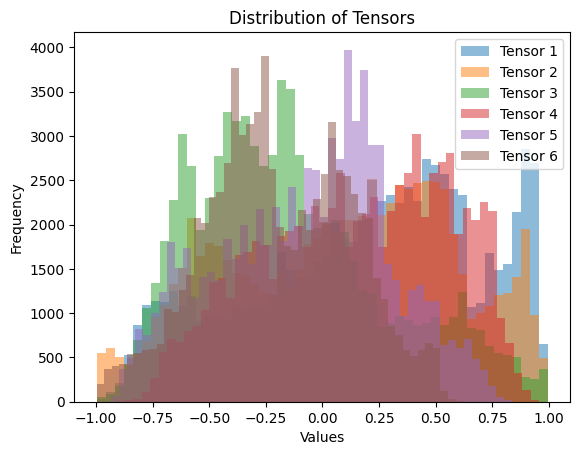

In [ ]:
import matplotlib.pyplot as plt

for i, tensor in enumerate(aligned):
    plt.hist(tensor.numpy().flatten(), bins=50, alpha=0.5, label=f'Tensor {i+1}')

plt.legend()
plt.title('Distribution of Tensors')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import vgg19
from torchvision.models import vgg19_bn
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module="torchvision.models._utils")

def to_onehot(targets, num_classes, device):
    targets = targets.to(torch.int64)

    onehot_targets = torch.zeros(targets.size(0), num_classes, device=device)
    onehot_targets.scatter_(1, targets.view(-1, 1), 1.0)
    return onehot_targets

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, negative_slope=0.2, use_batchnorm=True):
        super(ConvBlock, self).__init__()
        layers = []
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding))
        if use_batchnorm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.LeakyReLU(negative_slope, inplace=True))
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)

class Encoder(nn.Module):
    def __init__(self, num_channels, num_latent):
        super(Encoder, self).__init__()

        self.resnet = InceptionResnetV1(pretrained='vggface2')

        self.fc_mean = nn.Linear(512, num_latent)
        self.fc_log_var = nn.Linear(512, num_latent)

    def reparameterize(self, z_mu, z_log_var):
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).to(device)
        z = z_mu + eps * torch.exp(z_log_var/2.)
        return z

    def forward(self, image_tensor):

        features = self.resnet(image_tensor)

        z_mean = self.fc_mean(features)
        z_log_var = self.fc_log_var(features)
        encoded = self.reparameterize(z_mean, z_log_var)

        return z_mean, z_log_var, encoded

def test_encoder():
    enc = Encoder(3,400);
    image = torch.randn(4,3,256,256)
    label = torch.arange(0, 4).view(-1,1)
    output = enc(image)
    print(output[0].shape)

#test_encoder()

In [ ]:
# (batch, num_latten )
# (batch, num_classes)
# concate(axis = 1)

In [ ]:
class Decoder(nn.Module):
    def __init__(self, num_channels, num_classes, num_latent):
        super(Decoder, self).__init__()

        self.num_latent = num_latent
        self.num_classes = num_classes
        self.num_channels = num_channels

        self.fc = nn.Linear(self.num_latent + self.num_classes , 64 * 16 * 16)

        self.deconv1 = ConvBlock(64 , 32, (3, 3), (1, 1), 1)
        self.deconv2 = ConvBlock(32, 16, (3, 3), (1, 1), 1)
        self.deconv3 = ConvBlock(16 , 8, (3, 3), (1, 1), 1)


        self.final_conv = nn.Conv2d(8, self.num_channels, (3, 3), (1, 1), 1)

    def forward(self, z, label):
        with torch.no_grad():
            onehot_targets = to_onehot(label, self.num_classes, device)
            encoded = torch.cat((z, onehot_targets), dim=1)

        x = F.relu(self.fc(encoded)).view(-1, 64, 16, 16)

        x = F.interpolate(x, scale_factor=2, mode='nearest')  # Upsample
        x = self.deconv1(x)

        x = F.interpolate(x, scale_factor=2, mode='nearest')  # Upsample
        x = self.deconv2(x)

        x = F.interpolate(x, scale_factor=2, mode='nearest')  # Upsample
        x = self.deconv3(x)

        x = F.interpolate(x, scale_factor=2, mode='nearest')  # Upsample
        x = self.final_conv(x)

        return torch.tanh(x)

In [ ]:
class Cvae(nn.Module):
    def __init__ (self,num_channels, num_classes, num_latent):
        super(Cvae,self).__init__()
        self.num_channels = num_channels
        self.num_classes  = num_classes
        self.num_latent  = num_latent
        self.encoder = Encoder(
            self.num_channels,
            self.num_latent
        )
        self.decoder = Decoder(
            self.num_channels,
            self.num_classes,
            self.num_latent
        )
    def forward(self,image, label):
        z_mean, z_log_var, encoded = self.encoder(image)
        decoded = self.decoder(encoded, label)

        return z_mean, z_log_var, encoded, decoded


In [ ]:
class CvaeLoss(nn.Module):
    def __init__(self, num_classes):
        super(CvaeLoss, self).__init__()
        self.num_classes = num_classes

    def kl_divergence_loss(self, z_mean, z_log_var):
        kl_loss = torch.sum(1 + z_log_var - torch.square(z_mean) - torch.exp(z_log_var))
        kl_loss *= -0.5
        return kl_loss

    def pixelwise_bce_loss(self, features, decoded):

        return F.mse_loss(decoded, features, reduction='mean')

    def forward(self, features, decoded, z_mean, z_log_var):
        kl_loss = self.kl_divergence_loss(z_mean, z_log_var)
        # Add condition (disabled for reconstruction loss)
        """
        onehot_targets = to_onehot(targets, self.num_classes, device)
        onehot_targets = onehot_targets.view(-1, self.num_classes, 1, 1)

        ones = torch.ones(features.size()[0],
                          self.num_classes,
                          features.size()[2],
                          features.size()[3],
                          dtype=features.dtype).to(device)
        ones = ones * onehot_targets
        x_con = torch.cat((features, ones), dim=1)
        """

        # Compute loss
        # pixelwise_bce_loss = F.binary_cross_entropy(decoded, x_con, reduction='sum')
        pixelwise_loss = self.pixelwise_bce_loss(features, decoded)
        total_loss = kl_loss + pixelwise_loss

        return total_loss

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from pathlib import Path

class ExpressionsDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = Path(root_dir)
        self.classes = ['smile', 'sad', 'angry','surprise']
        self.data = self.load_data()

    def load_data(self):
        data = []
        for i, class_name in enumerate(self.classes):
            class_dir = os.path.join(self.root_dir, class_name)
            for dirpath, dirnames, filenames in os.walk(class_dir):
                for filename in filenames:
                    file_path = os.path.join(dirpath, filename)
                    data.append((file_path,i))
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        file_path, label = self.data[idx]
        tensor_data = torch.load(file_path)

        return tensor_data, label


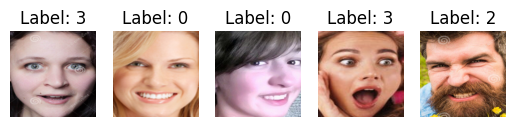

In [ ]:
import matplotlib.pyplot as plt

def denormalize(image, mean=0.5, std=0.5):
    denormalized_image = (image * std) + mean
    return denormalized_image

def visualize_examples():
    dataset_dir = '/content/drive/MyDrive/2_cropped_VAE_dataset'
    custom_dataset = ExpressionsDataset(dataset_dir)
    data_loader = DataLoader(custom_dataset, batch_size=5, shuffle=True)
    images, labels = next(iter(data_loader))
    images = images.permute(0, 2, 3, 1).numpy()

    # Denormalize the images
    denormalized_images = [denormalize(image) for image in images]

    # Visualize the denormalized images
    for i in range(len(denormalized_images)):
        plt.subplot(1, 5, i + 1)
        plt.imshow(denormalized_images[i])
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')

    plt.show()

visualize_examples()

In [ ]:
import time

def test_cvae():
    num_channels = 3
    num_classes = 3
    num_latent = 400

    cvae_model = Cvae(num_channels, num_classes, num_latent)
    cvae_loss = CvaeLoss(num_classes)

    batch_size = 32
    image_size = (num_channels, 256, 256)

    dummy_image, dummy_label = next(iter(data_loader))
    # Timing for encoding
    start_time = time.time()
    z_mean, z_log_var, encoded = cvae_model.encoder(dummy_image)
    encoding_time = time.time() - start_time
    assert z_mean.shape == (batch_size, num_latent)
    assert z_log_var.shape == (batch_size, num_latent)
    assert encoded.shape == (batch_size, num_latent)

    # Timing for decoding
    start_time = time.time()
    decoded = cvae_model.decoder(encoded, dummy_label.view(-1,1))
    decoding_time = time.time() - start_time



    print("Encoding time:", encoding_time, "seconds")
    print("Decoding time:", decoding_time, "seconds")

    loss = cvae_loss(dummy_image, decoded, z_mean, z_log_var)

    print("Loss:", loss.item())

    print("CVAE test passed!")

test_cvae()

Encoding time: 7.261261701583862 seconds
Decoding time: 0.4861421585083008 seconds
Loss: 13.031919479370117
CVAE test passed!


In [ ]:
learning_rate = 0.0001
num_epochs = 100
batch_size = 32

num_classes = 4
num_channels = 3
num_latent = 400

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cvae_model = Cvae(num_channels, num_classes, num_latent).to(device)
optimizer = torch.optim.Adam(cvae_model.parameters(), lr=learning_rate)

cvae_loss = CvaeLoss(num_classes).to(device)

dataset_dir = '/content/drive/MyDrive/2_cropped_VAE_dataset'
dataset = ExpressionsDataset(dataset_dir)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True,num_workers = workers)

In [ ]:
from tqdm import tqdm

with torch.no_grad():
    initial_loss = 0
    for batch_idx, (input, targets) in tqdm(enumerate(data_loader), total=len(data_loader), desc='Initial Loss Calculation', leave=False):
        input = input.to(device)
        targets = targets.view(-1, 1).to(device)

        z_mean, z_log_var, encoded, decoded = cvae_model(input, targets)
        initial_loss += cvae_loss(input, decoded, z_mean, z_log_var).item()

    initial_loss /= len(data_loader)
    print(f'Initial Loss: {initial_loss:.4f}')

Initial Loss: 11.8822


In [ ]:
losses = []

In [ ]:
from tqdm import tqdm


for epoch in range(num_epochs):
    acc_loss = 0
    cost = 0
    for batch_idx, (input, targets) in tqdm(enumerate(data_loader), total=len(data_loader), desc=f'Epoch {epoch + 1}/{num_epochs}', leave=False):

        input = input.to(device)
        #print(targets.shape)

        #print(targets.shape)
        targets = targets.view(-1,1).to(device)

        ### FORWARD AND BACK PROP
        z_mean, z_log_var, encoded, decoded = cvae_model(input, targets)


        ### Add condition
        # Disabled for reconstruction loss as it gives poor results
        """
        onehot_targets = to_onehot(targets, num_classes, device)
        onehot_targets = onehot_targets.view(-1, num_classes, 1, 1)

        ones = torch.ones(features.size()[0],
                          num_classes,
                          features.size()[2],
                          features.size()[3],
                          dtype=features.dtype).to(device)
        ones = ones * onehot_targets
        x_con = torch.cat((features, ones), dim=1)
        """

        ### Compute loss
        #pixelwise_bce = F.binary_cross_entropy(decoded, x_con, reduction='sum')

        cost = cvae_loss(input, decoded, z_mean, z_log_var)


        ### UPDATE MODEL PARAMETERS
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        ### LOGGING
        acc_loss += cost.item()
    losses.append(cost.item() / len(data_loader))

    print('Epoch: %03d/%03d | Cost: %.4f'
            %(epoch+1, num_epochs , losses[-1] ))

Epoch: 001/100 | Cost: 0.1039


Epoch: 002/100 | Cost: 0.0751


Epoch: 003/100 | Cost: 0.0863


Epoch: 004/100 | Cost: 0.0819


Epoch: 005/100 | Cost: 0.0744


Epoch: 006/100 | Cost: 0.0696


Epoch: 007/100 | Cost: 0.0671


Epoch: 008/100 | Cost: 0.0628


Epoch: 009/100 | Cost: 0.0629


Epoch: 010/100 | Cost: 0.0490


Epoch: 011/100 | Cost: 0.0564


Epoch: 012/100 | Cost: 0.0504


Epoch: 013/100 | Cost: 0.0554


Epoch: 014/100 | Cost: 0.0552


Epoch: 015/100 | Cost: 0.0439


Epoch: 016/100 | Cost: 0.0543


Epoch: 017/100 | Cost: 0.0442


Epoch: 018/100 | Cost: 0.0415


Epoch: 019/100 | Cost: 0.0453


Epoch: 020/100 | Cost: 0.0354


Epoch: 021/100 | Cost: 0.0357


Epoch: 022/100 | Cost: 0.0410


Epoch: 023/100 | Cost: 0.0428


Epoch: 024/100 | Cost: 0.0379


Epoch: 025/100 | Cost: 0.0373


Epoch: 026/100 | Cost: 0.0349


Epoch: 027/100 | Cost: 0.0338


Epoch: 028/100 | Cost: 0.0298


Epoch: 029/100 | Cost: 0.0323


Epoch: 030/100 | Cost: 0.0369


Epoch: 031/100 | Cost: 0.0277


Epoch: 032/100 | Cost: 0.0313


Epoch: 033/100 | Cost: 0.0298


Epoch: 034/100 | Cost: 0.0308


Epoch: 035/100 | Cost: 0.0272


Epoch: 036/100 | Cost: 0.0313


Epoch: 037/100 | Cost: 0.0263


Epoch: 038/100 | Cost: 0.0312


Epoch: 039/100 | Cost: 0.0288


Epoch: 040/100 | Cost: 0.0239


Epoch: 041/100 | Cost: 0.0304


Epoch: 042/100 | Cost: 0.0234


Epoch: 043/100 | Cost: 0.0302


Epoch: 044/100 | Cost: 0.0315


Epoch: 045/100 | Cost: 0.0211


Epoch: 046/100 | Cost: 0.0309


Epoch: 047/100 | Cost: 0.0277


Epoch: 048/100 | Cost: 0.0228


Epoch: 049/100 | Cost: 0.0241


Epoch: 050/100 | Cost: 0.0335


Epoch: 051/100 | Cost: 0.0241


Epoch: 052/100 | Cost: 0.0251


Epoch: 053/100 | Cost: 0.0304


Epoch: 054/100 | Cost: 0.0215


Epoch: 055/100 | Cost: 0.0334


Epoch: 056/100 | Cost: 0.0179


Epoch: 057/100 | Cost: 0.0290


Epoch: 058/100 | Cost: 0.0281


Epoch: 059/100 | Cost: 0.0275


Epoch: 060/100 | Cost: 0.0240


Epoch: 061/100 | Cost: 0.0245


Epoch: 062/100 | Cost: 0.0290


Epoch: 063/100 | Cost: 0.0249


Epoch: 064/100 | Cost: 0.0298


Epoch: 065/100 | Cost: 0.0331


Epoch: 066/100 | Cost: 0.0240


Epoch: 067/100 | Cost: 0.0260


Epoch: 068/100 | Cost: 0.0316


Epoch: 069/100 | Cost: 0.0237


Epoch: 070/100 | Cost: 0.0354


Epoch: 071/100 | Cost: 0.0320


Epoch: 072/100 | Cost: 0.0263


Epoch: 073/100 | Cost: 0.0273


Epoch: 074/100 | Cost: 0.0195


KeyboardInterrupt: ignored

In [ ]:
data,target = data_loader.dataset[0]
data = torch.unsqueeze(data,dim = 0).to(device)
target = torch.tensor(target).view(1,1).to(device)
print(data.shape)
print(target.shape)

torch.Size([1, 3, 256, 256])
torch.Size([1, 1])


In [ ]:
device

device(type='cuda')

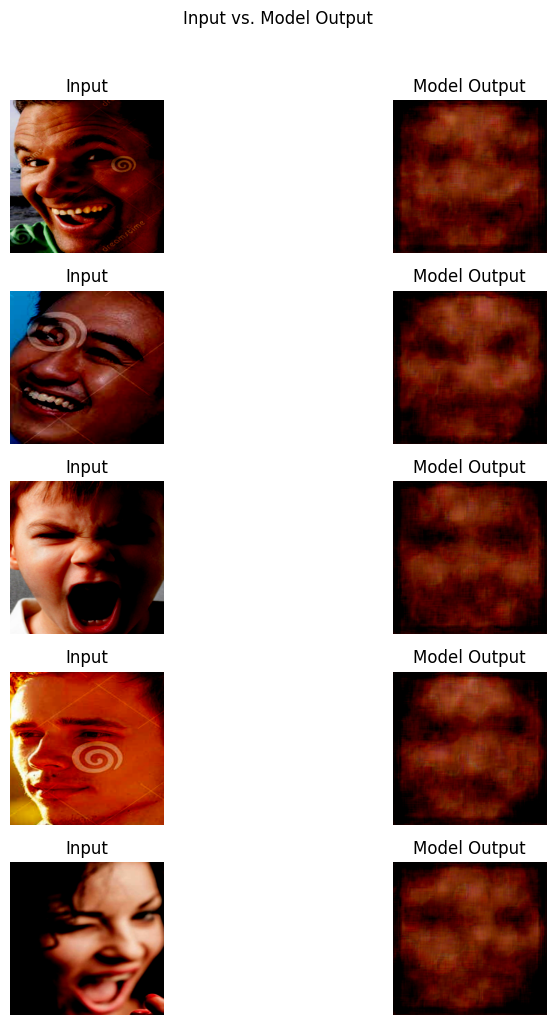

In [ ]:

import matplotlib.pyplot as plt
import numpy as np

# Set model to evaluation mode
cvae_model.eval()

# Choose a few random samples from the dataset
num_samples = 5
random_indices = np.random.choice(len(data_loader.dataset), size=num_samples, replace=False)

# Create a subplot for each sample
fig, axes = plt.subplots(num_samples, 2, figsize=(10, 2*num_samples))
fig.suptitle('Input vs. Model Output', y=1.02)

for i, idx in enumerate(random_indices):
    # Get input data
    data,target = data_loader.dataset[idx]
    data = torch.unsqueeze(data,dim = 0).to(device)
    target = torch.tensor(target).view(1,1).to(device)
    # Forward pass through the model
    with torch.no_grad():
        z_mean, z_log_var, encoded, decoded = cvae_model(data, target)

    # Convert tensors to numpy arrays for plotting
    data = data.permute(0,2,3,1).cpu().numpy().squeeze()
    reconstructed_data = decoded.permute(0,2,3,1).cpu().numpy().squeeze()

    #Plot the input and reconstructed images side by side
    axes[i, 0].imshow(data, cmap='gray')
    axes[i, 0].set_title('Input')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(reconstructed_data, cmap='gray')
    axes[i, 1].set_title('Model Output')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()